Dependencies, Packages

In [9]:
!pip install requests pillow requests_toolbelt
!pip install roboflow
!pip install inference
!pip install 'inference[sam]'
!pip install 'inference[clip]'
!pip install 'inference[gaze]'
!pip install 'inference[grounding-dino]'
!pip install 'inference[yolo-world]'
!pip install 'inference[transformers]'

 Import Necessary Libraries

In [10]:
from io import BytesIO
import requests
import supervision as sv
from inference import get_model
from PIL import Image, ImageFile
import matplotlib.pyplot as plt


Load Pre-trained Model

Run Inference and Remove Background

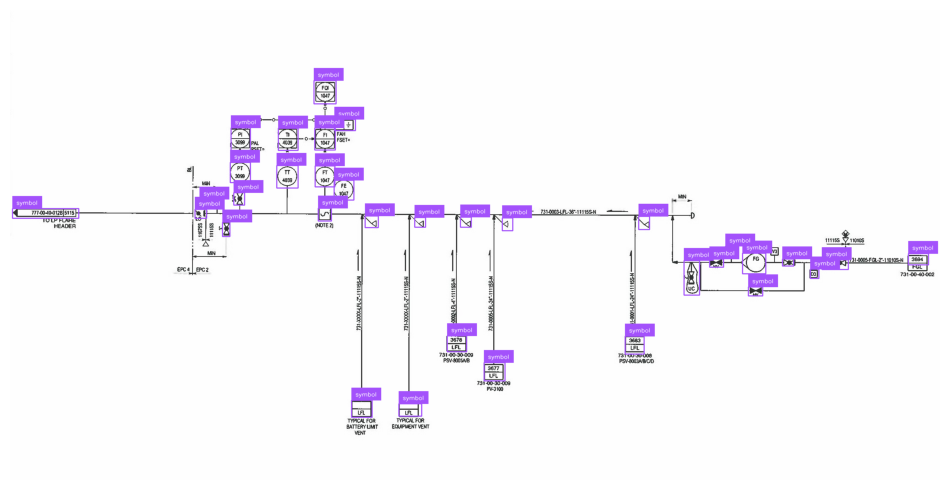

In [11]:
# Modified function to handle both URLs and local file paths
def load_image(source: str) -> ImageFile:
    """Loads an image from a URL or a local file path."""
    try:
        # Attempt to load from URL
        response = requests.get(source)
        response.raise_for_status()  # check if the request was successful
        image = Image.open(BytesIO(response.content))
    except requests.exceptions.MissingSchema:
        # If it's not a URL, load from local file path
        image = Image.open(source)
    return image


# load the image
image = load_image("/content/input.jpg") # Call the modified load_image function

# load a pre-trained yolov8n model
model = get_model(model_id="symbols-only-zx4p7-l5bho/4")

# run inference on our chosen image, image can be a url, a numpy array, a PIL image, etc.
results = model.infer(image)[0]

# load the results into the supervision Detections api
detections = sv.Detections.from_inference(results)

# create supervision annotators
bounding_box_annotator = sv.BoxAnnotator()
label_annotator = sv.LabelAnnotator()

# annotate the image with our inference results
annotated_image = bounding_box_annotator.annotate(scene=image, detections=detections)
annotated_image = label_annotator.annotate(scene=annotated_image, detections=detections)

# display the image
sv.plot_image(annotated_image)

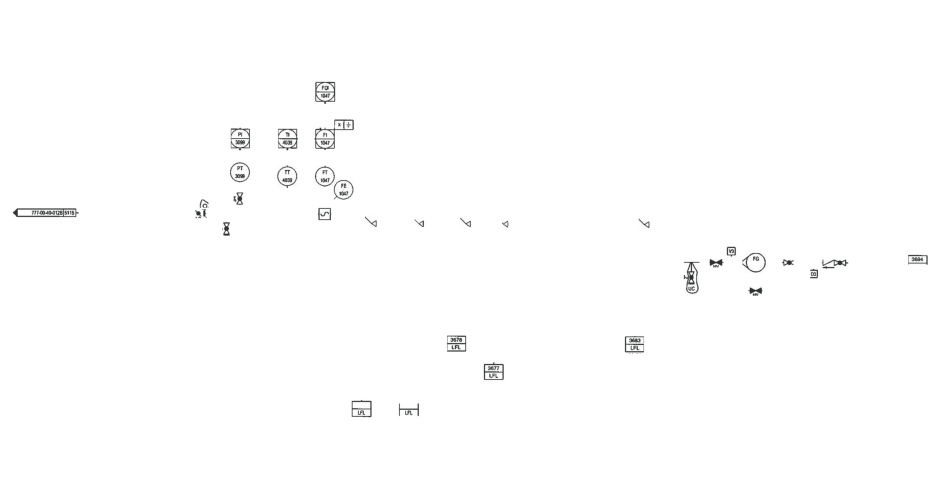

In [12]:
import cv2
import numpy as np
def remove_background(image_path):
    """Removes background and keeps only detected objects."""

    # Load the image using OpenCV
    image = cv2.imread(image_path)
    height, width = image.shape[:2]

    # Run inference and get results
    results = model.infer(image_path)[0]

    # Convert results to supervision format
    detections = sv.Detections.from_inference(results)

    # Create a transparent background (RGBA)
    # Create a white background (RGBA)
    clean_image = np.ones((height, width, 4), dtype=np.uint8) * 255

    # Iterate over detections and place them on the transparent background
    for box in detections.xyxy:
        x1, y1, x2, y2 = map(int, box)
        object_crop = image[y1:y2, x1:x2]

        # Convert BGR to BGRA (add alpha channel)
        object_crop = cv2.cvtColor(object_crop, cv2.COLOR_BGR2BGRA)
        object_crop[:, :, 3] = 255  # Set alpha channel to 255 (fully opaque)

        # Place detected object on transparent background
        clean_image[y1:y2, x1:x2] = object_crop

    # Display the result using supervision
    sv.plot_image(clean_image)

# Path to input image
image_path = "/content/input.jpg"
remove_background(image_path)
